In [246]:
# 更改内容：
# 1.0参考网文：天池精准医疗大赛——人工智能辅助糖尿病遗传风险预测：（已加入xgb）
# 特征处理：不多，但是部分可以借鉴
# 模型部分：使用了xgb，这里可以借鉴xgb的使用方法
# 2.0参考：learn from kaggle
# 特征处理后，对比精度变化

In [247]:
#coding=utf-8
import time
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
from dateutil.parser import parse
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from dateutil.parser import parse

In [248]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings

def ignore_warn(*args ,**kwargs):
    pass
warnings.warn = ignore_warn

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [249]:
# 第一部分：数据分析
train_analysis = pd.read_csv('d_train_20180102.csv',encoding='gb2312')
test_analysis = pd.read_csv('d_test_A_20180102.csv',encoding='gb2312')
print('train shape',train_analysis.shape)
print('test shape',test_analysis.shape)
# 分析：训练集中含有血糖维度多一维

train shape (5642, 42)
test shape (1000, 41)


In [250]:
# 查看特征名称
print(train_analysis.columns)

Index(['id', '性别', '年龄', '体检日期', '*天门冬氨酸氨基转换酶', '*丙氨酸氨基转换酶', '*碱性磷酸酶',
       '*r-谷氨酰基转换酶', '*总蛋白', '白蛋白', '*球蛋白', '白球比例', '甘油三酯', '总胆固醇',
       '高密度脂蛋白胆固醇', '低密度脂蛋白胆固醇', '尿素', '肌酐', '尿酸', '乙肝表面抗原', '乙肝表面抗体', '乙肝e抗原',
       '乙肝e抗体', '乙肝核心抗体', '白细胞计数', '红细胞计数', '血红蛋白', '红细胞压积', '红细胞平均体积',
       '红细胞平均血红蛋白量', '红细胞平均血红蛋白浓度', '红细胞体积分布宽度', '血小板计数', '血小板平均体积',
       '血小板体积分布宽度', '血小板比积', '中性粒细胞%', '淋巴细胞%', '单核细胞%', '嗜酸细胞%', '嗜碱细胞%',
       '血糖'],
      dtype='object')


In [251]:
print(train_analysis.head())

   id 性别  年龄        体检日期  *天门冬氨酸氨基转换酶  *丙氨酸氨基转换酶  *碱性磷酸酶  *r-谷氨酰基转换酶   *总蛋白  \
0   1  男  41  12/10/2017       24.960     23.100  99.590      20.230 76.880   
1   2  男  41  19/10/2017       24.570     36.250  67.210      79.000 79.430   
2   3  男  46  26/10/2017       20.820     15.230  63.690      38.170 86.230   
3   4  女  22  25/10/2017       14.990     10.590  74.080      20.220 70.980   
4   5  女  48  26/10/2017       20.070     14.780  75.790      22.720 78.050   

     白蛋白  ...    血小板计数  血小板平均体积  血小板体积分布宽度  血小板比积  中性粒细胞%  淋巴细胞%  单核细胞%  \
0 49.600  ...  166.000    9.900     17.400  0.164  54.100 34.200  6.500   
1 47.760  ...  277.000    9.200     10.300  0.260  52.000 36.700  5.800   
2 48.000  ...  241.000    8.300     16.600  0.199  48.100 40.300  7.700   
3 44.020  ...  252.000   10.300     10.800  0.260  41.700 46.500  6.700   
4 41.830  ...  316.000   11.100     14.000  0.350  56.600 33.100  9.100   

   嗜酸细胞%  嗜碱细胞%    血糖  
0  4.700  0.600 6.060  
1  4.700  0.800 5.390  
2 

In [252]:
# 查看缺失值比例
data_analysis = pd.concat([train_analysis,test_analysis],axis=0)
print(data_analysis.isnull().sum()/len(data_analysis))
# 分析：乙肝类特征缺失严重，这里对其进行单独分析，确认特征和血糖之间的数据关系

*r-谷氨酰基转换酶    0.212
*丙氨酸氨基转换酶     0.212
*天门冬氨酸氨基转换酶   0.212
*总蛋白          0.212
*球蛋白          0.212
*碱性磷酸酶        0.212
id            0.000
中性粒细胞%        0.003
乙肝e抗体         0.769
乙肝e抗原         0.769
乙肝核心抗体        0.769
乙肝表面抗体        0.769
乙肝表面抗原        0.769
低密度脂蛋白胆固醇     0.210
体检日期          0.000
单核细胞%         0.003
嗜碱细胞%         0.003
嗜酸细胞%         0.003
尿素            0.237
尿酸            0.237
年龄            0.000
性别            0.000
总胆固醇          0.210
淋巴细胞%         0.003
甘油三酯          0.210
白球比例          0.212
白细胞计数         0.003
白蛋白           0.212
红细胞体积分布宽度     0.003
红细胞压积         0.003
红细胞平均体积       0.003
红细胞平均血红蛋白浓度   0.003
红细胞平均血红蛋白量    0.003
红细胞计数         0.003
肌酐            0.237
血小板体积分布宽度     0.004
血小板平均体积       0.004
血小板比积         0.004
血小板计数         0.003
血糖            0.151
血红蛋白          0.003
高密度脂蛋白胆固醇     0.210
dtype: float64


Text(0.5,0,'乙肝e抗体')

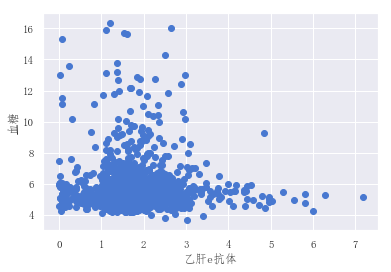

In [253]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong']
train_analysis['乙肝e抗体'] = train_analysis['乙肝e抗体'].dropna()
fig ,ax = plt.subplots()
ax.scatter(x = train_analysis['乙肝e抗体'],y=train_analysis['血糖'])
plt.ylabel('血糖')
plt.xlabel('乙肝e抗体')

D:\02_Tools\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 5.63 and sigma = 1.54



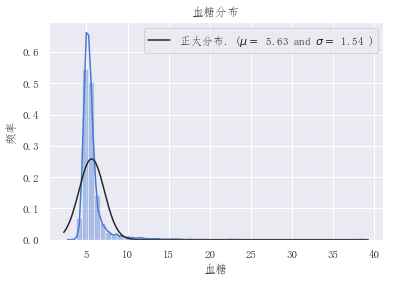

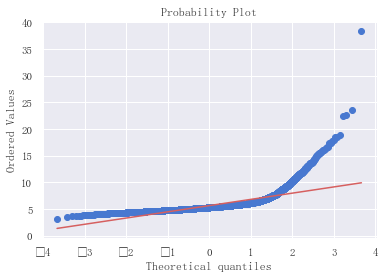

In [254]:
# 对要预测的血糖进行分析
sns.distplot(train_analysis['血糖'], fit=norm)

(mu,sigma) = norm.fit(train_analysis['血糖'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['正太分布. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('频率')
plt.title('血糖分布')

fig = plt.figure()
res = stats.probplot(train_analysis['血糖'], plot=plt)
plt.show()
# 分析：
# 1. 首先分布不服从正太分布，需要纵向压缩和横向拓展的过程
# 2. 分布的概率曲线同样是非线性的，后期需要对其进行矫正，一般使用使用log

D:\02_Tools\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 0.37 and sigma = 0.00



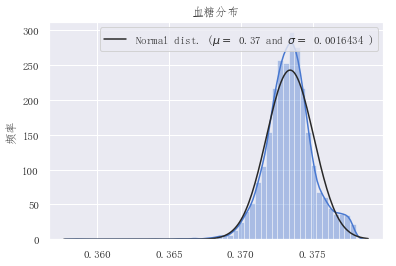

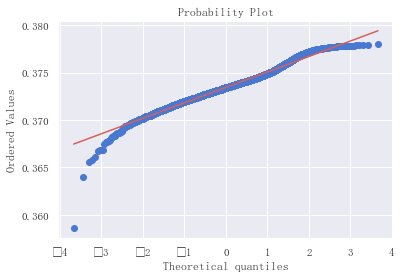

In [255]:
#  Y = log(1+X), 说是可以把这个特征的分布正态化, 使其更加符合后面数据挖掘方法对数据分布的假设
# 后期直接使用了log(1+x)进行校正，并使用expm1对校正后数据产生的结果进行反向校正。
from scipy.special import boxcox, inv_boxcox

tmp,lambda_  = stats.boxcox(train_analysis['血糖'])
sns.distplot(tmp,fit=norm)
(mu,sigma) = norm.fit(tmp)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.7f} )'.format(mu, sigma)], loc='best')
plt.ylabel('频率')
plt.title('血糖分布')

fig = plt.figure()
res = stats.probplot(tmp, plot=plt)
plt.show()

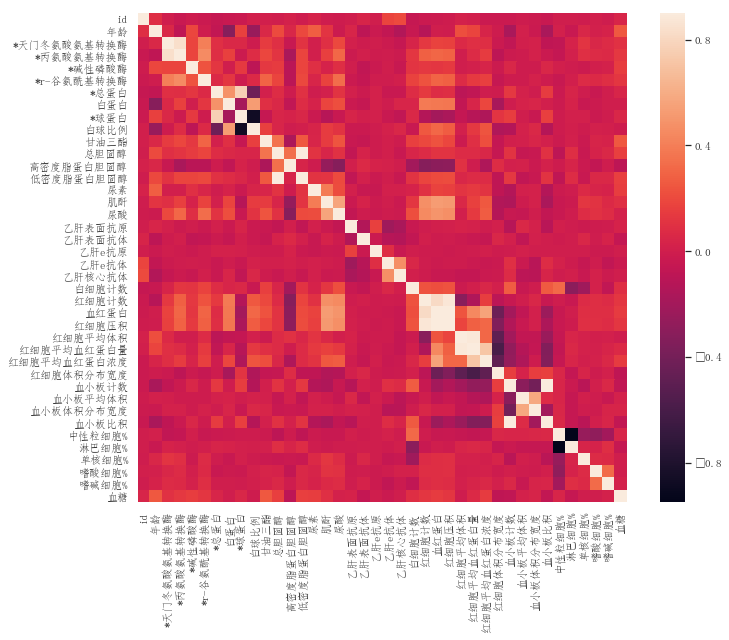

In [256]:
# 绘制热力图，确定不同特征之间的相似度
corrmat = train_analysis.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.9,square=True)
# 分析：
# 相似度越高，颜色越浅

In [257]:
# 特征工程部分
# 通过加减乘除等对特征进行组合，增加新的特征

In [258]:
def change(name):
    df = pd.read_csv(name,encoding='gb2312')
    index = ['尿素','*r-谷氨酰基转换酶','尿酸','*碱性磷酸酶','红细胞计数','血小板计数','血小板比积',
         '嗜酸细胞%','红细胞平均体积','红细胞体积分布宽度','红细胞平均血红蛋白浓度']
    for i in index:
        for j in index:
            if i == j:
                continue
            else:
                df['{}/{}'.format(i,j)] = df[i]/df[j]
    return df

In [259]:
df1 = change('d_train_20180102.csv')
df1.to_csv('train_change.csv', index=False)
print(df1.shape)

df2 = change('d_test_A_20180102.csv')
df2.to_csv('test_change.csv', index=False)
print(df2.shape)

df3 = change('d_test_B_20180128.csv')
df3.to_csv('test_change_B.csv', index=False)
print(df3.shape)

# def4就是加入了A榜中测试集的数据，相当于增加了B榜训练集样本
df4 = change('d_train_20180102_add.csv')
df4.to_csv('train_change_add.csv', index=False)
print(df4.shape)


(5642, 152)
(1000, 151)
(1000, 151)
(6642, 152)


In [260]:
train = pd.read_csv('train_change_add.csv')
test = pd.read_csv('test_change_B.csv')


In [261]:
traincopy = train.copy()
traincopy1 = train.copy()

testcopy = test.copy()
train["血糖"] = np.log1p(train["血糖"]) #先对血糖进行log（x+1）处理

In [262]:
# 特征重要性排序
# 分析：特征重要性利用lasso进行求得，也就是lasso训练后的不同特征权重的大小；
# 权重越大说明特征的作用越大。但是，实际中特征为0并不一定指特征重要性为0.这里仅仅
# 使用特征重要性作为一个参考。
from sklearn.linear_model import Lasso

y_scaled = traincopy['血糖']
traincopy.drop('血糖',axis=1, inplace=True)
traincopy['体检日期'] = (pd.to_datetime(traincopy['体检日期']) - parse('2017-10-09')).dt.days
traincopy['性别'] = traincopy['性别'].map({'男': 1, '女': 0})
# traincopy.fillna(traincopy.mean(axis=0), inplace=True)
# traincopy.fillna(traincopy.fillna(traincopy.mean(axis=0), inplace=True)

In [263]:
traincopy = traincopy.fillna(traincopy.mean()).clip(-1e11,1e11)

lasso=Lasso(alpha=0.001)
lasso.fit(traincopy, y_scaled)
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index = traincopy.columns)

FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
红细胞平均血红蛋白浓度/尿酸,0.703
尿素,0.542
红细胞计数,0.508
红细胞平均体积/*碱性磷酸酶,0.319
性别,0.242
*r-谷氨酰基转换酶/红细胞平均体积,0.201
红细胞平均血红蛋白浓度/红细胞体积分布宽度,0.176
*碱性磷酸酶/红细胞体积分布宽度,0.172
甘油三酯,0.134
红细胞平均体积/*r-谷氨酰基转换酶,0.122


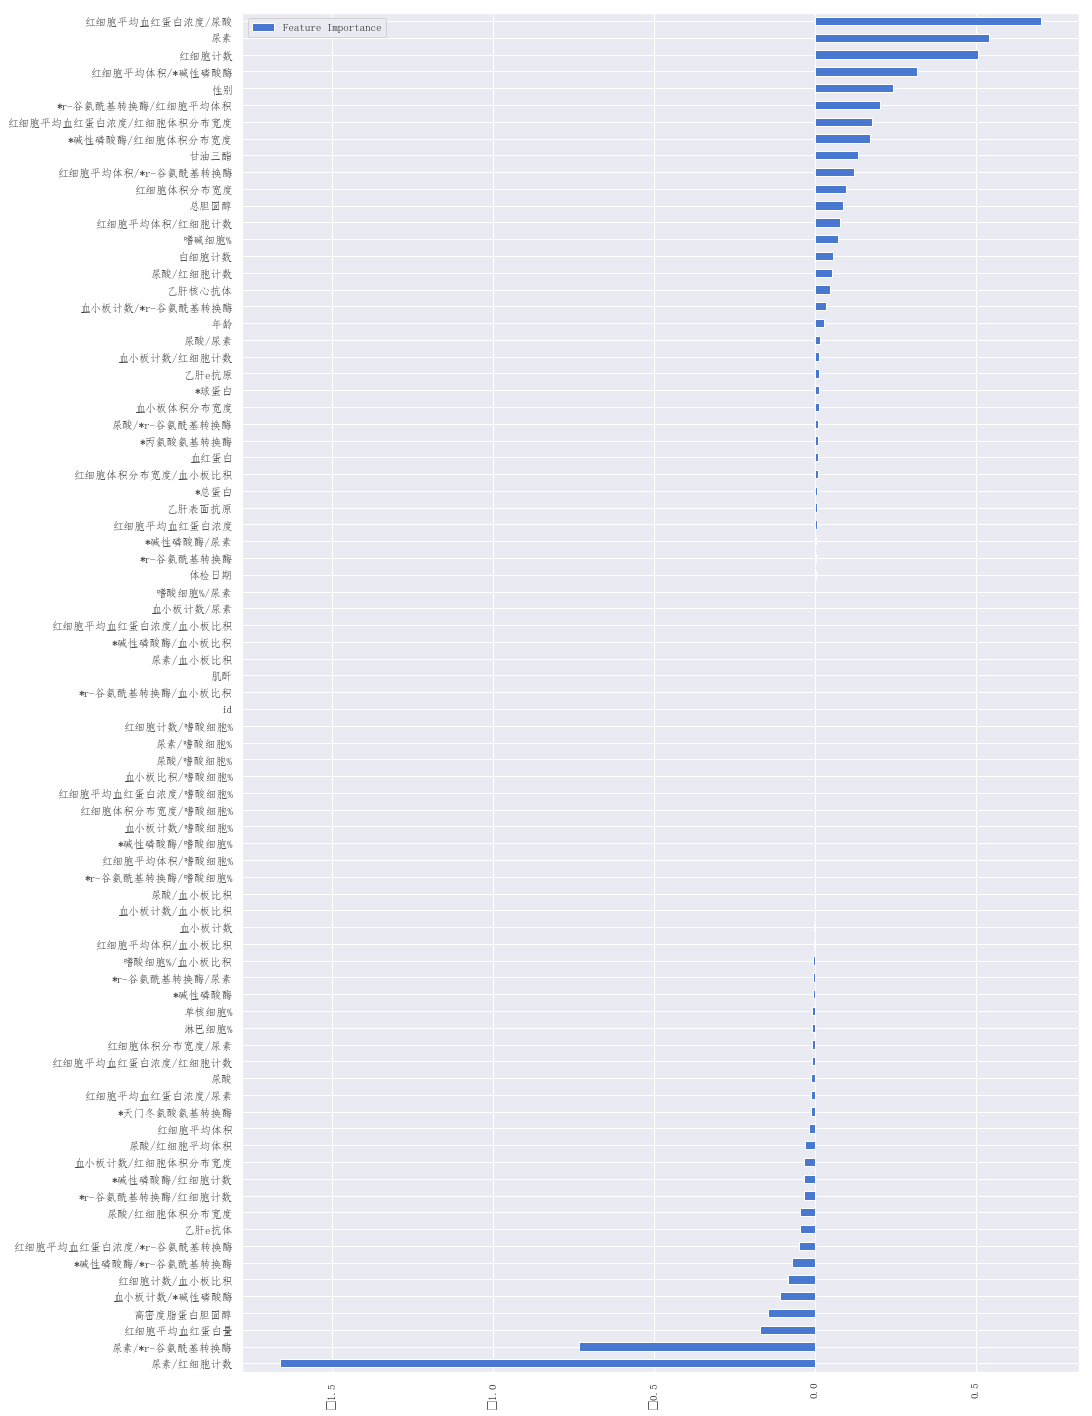

In [264]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [265]:
def make_feat(train, test):
    train_id = train.id.values.copy()
    test_id = test.id.values.copy()
    data = pd.concat([train, test])

    data['性别'] = data['性别'].map({'男': 1, '女': 0})
    data['体检日期'] = (pd.to_datetime(data['体检日期']) - parse('2017-10-09')).dt.days

    data.fillna(data.mean(axis=0), inplace=True)

    train_feat = data[data.id.isin(train_id)]
    test_feat = data[data.id.isin(test_id)]

    return train_feat, test_feat

In [266]:
train_feat, test_feat = make_feat(train, test)
train_feat_copy, test_feat_copy = make_feat(traincopy1, testcopy)

In [267]:
train_feat.drop(['id'], axis=1, inplace=True)
test_feat.drop(['id'], axis=1, inplace=True)
# test_feat.drop(['体检日期' , '乙肝表面抗原' ,  '乙肝e抗原' , '乙肝e抗体'
#                   , '乙肝核心抗体'], axis=1, inplace=True)

In [268]:
predictors = [f for f in test_feat.columns if f not in ['血糖']]

In [269]:
# predictors.head()
# AttributeError: 'list' object has no attribute 'head'
print(len(predictors))

150


In [270]:
# print(y_scaled.head())
# print(y_scaled.isnull().sum())

In [271]:
# np.isnan(train_feat[predictors]).any()
# train_feat[predictors].isnull().sum()

In [272]:
# def evalerror(pred, df):
#     label = df.get_label().values.copy()
#     score = mean_squared_error(label, pred) * 0.5
#     return ('0.5mse', score, False)

In [273]:
print('开始训练...')
# 备用参数，这里没有用到
params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'sub_feature': 0.8,
    'num_leaves': 60,
    'colsample_bytree': 0.7,
    'feature_fraction': 0.7,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}

def lgb_train(train_feat,test_feat):
    print('开始lgb_CV 5折训练:')
    t0 = time.time()
    train_preds = np.zeros(train_feat.shape[0])
    test_preds = np.zeros((test_feat.shape[0], 5))
    kf = KFold(len(train_feat), n_folds=5, shuffle=True, random_state=500)
    for i, (train_index, test_index) in enumerate(kf):
        print('第{}次训练...'.format(i))
        train_feat1 = train_feat.iloc[train_index]
        train_feat2 = train_feat.iloc[test_index]
        model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=8,
                                      learning_rate=0.02, n_estimators=400,
                                      max_bin=40, bagging_fraction=0.9,
                                      bagging_freq=10, feature_fraction=0.5,
                                      feature_fraction_seed=10, bagging_seed=10,
                                      min_data_in_leaf=80, nthread=8,
                                      min_sum_hessian_in_leaf=0.2)
        gbm = model_lgb.fit(train_feat1[predictors], train_feat1['血糖'])
        train_preds[test_index] += gbm.predict(train_feat2[predictors])
        test_preds[:, i] = gbm.predict(test_feat[predictors])
    return train_preds,test_preds


开始训练...


In [274]:
train_preds,test_preds = lgb_train(train_feat,test_feat)
train_preds = np.expm1(train_preds)
test_preds = np.expm1(test_preds)  #血糖值回算：exp（x）-1

开始lgb_CV 5折训练:
第0次训练...
第1次训练...
第2次训练...
第3次训练...
第4次训练...


In [275]:
#对预测值大于6.4的血糖进行后处理
for i in range(len(train_preds)):
    if train_preds[i] >= 6.4:
        train_preds[i] = np.expm1((train_preds[i] - 6.4) * 0.8)*0.45 + train_preds[i]

test_preds1 = test_preds.mean(axis=1)

In [276]:
ol = pd.read_csv('d_answer_b_20180130.csv', encoding='gb2312')

In [277]:
for i in range(len(test_preds1)):
    if test_preds1[i] >= 6.4:
        test_preds1[i] = np.expm1((test_preds1[i] - 6.4) * 0.8)*0.45 + test_preds1[i]

print('线下得分：    {}'.format(mean_squared_error(train_feat_copy['血糖'], train_preds) * 0.5))
print('线上得分：    {}'.format(mean_squared_error(ol['血糖'], test_preds1) * 0.5))

线下得分：    0.9403317533835616
线上得分：    0.6091895181714105


In [278]:
import xgboost as xgb

print('XGB开始训练:')

def change_for_xgb(res):
    res['性别'] = res['性别'].map({'男': 1, '女': 0})
    res['体检日期'] = (pd.to_datetime(res['体检日期']) - parse('2017-10-09')).dt.days
    res.drop(['id'], axis=1, inplace=True)
    res.fillna(res.mean(axis=0), inplace=True)
    return res

train = change_for_xgb(train)
test = change_for_xgb(test)

XGB开始训练:


In [281]:
y_train = train["血糖"]
x_train = train.drop(['血糖'], axis=1)
y_test = test;

In [282]:
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(y_test)

params = {'booster': 'gbtree',
          'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'max_depth': 7,#通常取值：3-10
          'gamma':0.2,#给定了所需的最低loss function的值
          'lambda': 100,
          'subsample': 1,#用于训练模型的子样本占整个样本集合的比例
          'colsample_bytree': 0.6,
          'min_child_weight': 12,  # 5~10,孩子节点中最小的样本权重和，即调大这个参数能够控制过拟合
          'eta': 0.01,#更新过程中用到的收缩步长，取值范围为：[0,1]
          'sample_type': 'uniform',
          'normalize': 'tree',
          'rate_drop': 0.1,
          'skip_drop': 0.9,
          'seed': 100,
          'nthread':-1
          }

watchlist = [(dtrain, '训练误差')]
model = xgb.train(params, dtrain, num_boost_round = 1000, evals=watchlist)  # 训练模型
# model = xgb.train(params, dtrain, num_boost_round = 1000)  # 训练模型

y_pred = model.predict(dtest)
test_preds_xgb = np.expm1(y_pred)  #血糖值回算：exp（x）-1

for i in range(len(test_preds1)):
    if test_preds1[i] >= 6.4:
        test_preds_xgb[i] = np.expm1((test_preds_xgb[i] - 6.4) * 0.8)*0.45 + test_preds_xgb[i]

# print('线下得分：    {}'.format(mean_squared_error(train_feat_copy['血糖'], train_preds) * 0.5))
print('线上得分：    {}'.format(mean_squared_error(ol['血糖'], test_preds_xgb) * 0.5))

[19:12:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[0]	训练误差-rmse:1.37417
[19:12:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[1]	训练误差-rmse:1.36084
[19:12:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[2]	训练误差-rmse:1.34765
[19:12:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[3]	训练误差-rmse:1.33459
[19:12:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[4]	训练误差-rmse:1.32166
[19:12:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, ma

[19:12:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[47]	训练误差-rmse:0.873076
[19:12:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[48]	训练误差-rmse:0.864805
[19:12:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[49]	训练误差-rmse:0.85662
[19:12:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[50]	训练误差-rmse:0.848518
[19:12:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[51]	训练误差-rmse:0.8405
[19:12:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned no

[19:12:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[95]	训练误差-rmse:0.55909
[19:12:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[96]	训练误差-rmse:0.554099
[19:12:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[97]	训练误差-rmse:0.549162
[19:12:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[98]	训练误差-rmse:0.544278
[19:12:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[99]	训练误差-rmse:0.539447
[19:12:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned 

[19:12:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[142]	训练误差-rmse:0.375406
[19:12:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[143]	训练误差-rmse:0.37247
[19:12:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[144]	训练误差-rmse:0.369568
[19:12:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[145]	训练误差-rmse:0.366704
[19:12:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[146]	训练误差-rmse:0.363874
[19:12:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pr

[19:12:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[188]	训练误差-rmse:0.271317
[19:12:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[189]	训练误差-rmse:0.269652
[19:12:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[190]	训练误差-rmse:0.268009
[19:12:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[191]	训练误差-rmse:0.266387
[19:12:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[192]	训练误差-rmse:0.264794
[19:12:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 p

[19:12:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=3
[234]	训练误差-rmse:0.213935
[19:12:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 16 pruned nodes, max_depth=2
[235]	训练误差-rmse:0.213046
[19:12:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[236]	训练误差-rmse:0.212168
[19:12:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 26 pruned nodes, max_depth=3
[237]	训练误差-rmse:0.211305
[19:12:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 32 pruned nodes, max_depth=2
[238]	训练误差-rmse:0.210454
[19:12:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra node

[19:12:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 70 pruned nodes, max_depth=4
[280]	训练误差-rmse:0.183991
[19:12:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 84 pruned nodes, max_depth=3
[281]	训练误差-rmse:0.183538
[19:12:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 74 pruned nodes, max_depth=3
[282]	训练误差-rmse:0.183099
[19:12:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 76 pruned nodes, max_depth=4
[283]	训练误差-rmse:0.182663
[19:12:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 56 pruned nodes, max_depth=3
[284]	训练误差-rmse:0.182237
[19:12:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra n

[326]	训练误差-rmse:0.168534
[19:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 102 pruned nodes, max_depth=5
[327]	训练误差-rmse:0.168287
[19:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 104 pruned nodes, max_depth=7
[328]	训练误差-rmse:0.168041
[19:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 94 pruned nodes, max_depth=6
[329]	训练误差-rmse:0.167802
[19:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 134 pruned nodes, max_depth=6
[330]	训练误差-rmse:0.167556
[19:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 116 pruned nodes, max_depth=5
[331]	训练误差-rmse:0.167323
[19:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[19:12:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 144 pruned nodes, max_depth=6
[373]	训练误差-rmse:0.159589
[19:12:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 142 pruned nodes, max_depth=7
[374]	训练误差-rmse:0.15944
[19:12:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 138 pruned nodes, max_depth=7
[375]	训练误差-rmse:0.159304
[19:12:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 104 pruned nodes, max_depth=6
[376]	训练误差-rmse:0.15917
[19:12:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 112 pruned nodes, max_depth=7
[377]	训练误差-rmse:0.159028
[19:12:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 ex

[19:12:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 114 pruned nodes, max_depth=7
[419]	训练误差-rmse:0.154171
[19:12:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 134 pruned nodes, max_depth=6
[420]	训练误差-rmse:0.154071
[19:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 108 pruned nodes, max_depth=5
[421]	训练误差-rmse:0.153991
[19:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 126 pruned nodes, max_depth=5
[422]	训练误差-rmse:0.153902
[19:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 122 pruned nodes, max_depth=6
[423]	训练误差-rmse:0.153808
[19:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 

[19:12:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 118 pruned nodes, max_depth=6
[465]	训练误差-rmse:0.150498
[19:12:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 140 pruned nodes, max_depth=7
[466]	训练误差-rmse:0.150427
[19:12:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 140 pruned nodes, max_depth=6
[467]	训练误差-rmse:0.15036
[19:12:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 128 pruned nodes, max_depth=6
[468]	训练误差-rmse:0.150293
[19:12:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 126 pruned nodes, max_depth=5
[469]	训练误差-rmse:0.150236
[19:12:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 e

[19:12:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 112 pruned nodes, max_depth=7
[511]	训练误差-rmse:0.147777
[19:12:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 54 pruned nodes, max_depth=7
[512]	训练误差-rmse:0.147727
[19:12:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 132 pruned nodes, max_depth=7
[513]	训练误差-rmse:0.147667
[19:12:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 86 pruned nodes, max_depth=7
[514]	训练误差-rmse:0.14761
[19:12:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 104 pruned nodes, max_depth=5
[515]	训练误差-rmse:0.14757
[19:12:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extr

[19:12:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 96 pruned nodes, max_depth=6
[558]	训练误差-rmse:0.145645
[19:12:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 122 pruned nodes, max_depth=5
[559]	训练误差-rmse:0.145599
[19:12:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 102 pruned nodes, max_depth=7
[560]	训练误差-rmse:0.145561
[19:12:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 70 pruned nodes, max_depth=6
[561]	训练误差-rmse:0.145523
[19:12:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 76 pruned nodes, max_depth=6
[562]	训练误差-rmse:0.145484
[19:12:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 ext

[19:12:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 132 pruned nodes, max_depth=6
[604]	训练误差-rmse:0.143809
[19:12:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 124 pruned nodes, max_depth=5
[605]	训练误差-rmse:0.143779
[19:12:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 136 pruned nodes, max_depth=5
[606]	训练误差-rmse:0.143744
[19:12:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 96 pruned nodes, max_depth=7
[607]	训练误差-rmse:0.14371
[19:12:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 68 pruned nodes, max_depth=6
[608]	训练误差-rmse:0.143676
[19:12:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 ext

[19:12:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 66 pruned nodes, max_depth=6
[651]	训练误差-rmse:0.142233
[19:12:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 102 pruned nodes, max_depth=4
[652]	训练误差-rmse:0.14221
[19:12:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 56 pruned nodes, max_depth=7
[653]	训练误差-rmse:0.142181
[19:12:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 110 pruned nodes, max_depth=7
[654]	训练误差-rmse:0.142147
[19:12:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 100 pruned nodes, max_depth=6
[655]	训练误差-rmse:0.142117
[19:12:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 ext

[19:12:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 96 pruned nodes, max_depth=4
[698]	训练误差-rmse:0.140894
[19:12:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 72 pruned nodes, max_depth=6
[699]	训练误差-rmse:0.140865
[19:12:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 54 pruned nodes, max_depth=5
[700]	训练误差-rmse:0.140847
[19:12:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 88 pruned nodes, max_depth=4
[701]	训练误差-rmse:0.140827
[19:12:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 154 pruned nodes, max_depth=5
[702]	训练误差-rmse:0.140794
[19:12:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extr

[19:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 60 pruned nodes, max_depth=6
[745]	训练误差-rmse:0.139774
[19:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 90 pruned nodes, max_depth=6
[746]	训练误差-rmse:0.139757
[19:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 64 pruned nodes, max_depth=7
[747]	训练误差-rmse:0.139737
[19:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 122 pruned nodes, max_depth=5
[748]	训练误差-rmse:0.139716
[19:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 86 pruned nodes, max_depth=4
[749]	训练误差-rmse:0.139701
[19:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extr

[19:13:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 130 pruned nodes, max_depth=5
[791]	训练误差-rmse:0.138934
[19:13:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 104 pruned nodes, max_depth=7
[792]	训练误差-rmse:0.138902
[19:13:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 62 pruned nodes, max_depth=6
[793]	训练误差-rmse:0.138887
[19:13:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 124 pruned nodes, max_depth=4
[794]	训练误差-rmse:0.138872
[19:13:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 94 pruned nodes, max_depth=7
[795]	训练误差-rmse:0.138851
[19:13:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 ex

[19:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 52 pruned nodes, max_depth=7
[838]	训练误差-rmse:0.13815
[19:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 112 pruned nodes, max_depth=4
[839]	训练误差-rmse:0.138141
[19:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 124 pruned nodes, max_depth=6
[840]	训练误差-rmse:0.138127
[19:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 116 pruned nodes, max_depth=6
[841]	训练误差-rmse:0.138107
[19:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 86 pruned nodes, max_depth=2
[842]	训练误差-rmse:0.138103
[19:13:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra 

[19:13:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 90 pruned nodes, max_depth=5
[885]	训练误差-rmse:0.137459
[19:13:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 170 pruned nodes, max_depth=6
[886]	训练误差-rmse:0.137436
[19:13:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 70 pruned nodes, max_depth=6
[887]	训练误差-rmse:0.137421
[19:13:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 86 pruned nodes, max_depth=7
[888]	训练误差-rmse:0.137402
[19:13:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 182 pruned nodes, max_depth=7
[889]	训练误差-rmse:0.137376
[19:13:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 ext

[19:13:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 100 pruned nodes, max_depth=0
[931]	训练误差-rmse:0.13678
[19:13:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 134 pruned nodes, max_depth=2
[932]	训练误差-rmse:0.136776
[19:13:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 98 pruned nodes, max_depth=4
[933]	训练误差-rmse:0.136768
[19:13:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 64 pruned nodes, max_depth=6
[934]	训练误差-rmse:0.136756
[19:13:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 100 pruned nodes, max_depth=5
[935]	训练误差-rmse:0.136745
[19:13:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra n

[19:13:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 138 pruned nodes, max_depth=3
[977]	训练误差-rmse:0.136329
[19:13:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 52 pruned nodes, max_depth=6
[978]	训练误差-rmse:0.136316
[19:13:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 102 pruned nodes, max_depth=3
[979]	训练误差-rmse:0.136308
[19:13:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 138 pruned nodes, max_depth=4
[980]	训练误差-rmse:0.136299
[19:13:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 86 pruned nodes, max_depth=3
[981]	训练误差-rmse:0.136294
[19:13:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra 

In [283]:
print('xgb+lgb综合得分：{}'.format(mean_squared_error(ol['血糖'], (0.5*test_preds_xgb+0.5*test_preds1)) * 0.5))

xgb+lgb综合得分：0.6117820119549304


D:\02_Tools\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


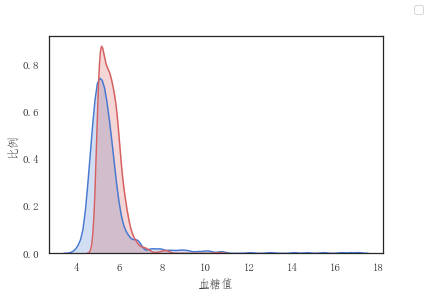

In [300]:
# 红色是预测结果，可以看出预测的结果还是偏高，尤其是在血糖值处在<6的水平下
import seaborn as sns

fig = plt.figure()
sns.set(style="white", palette="muted", color_codes=True)
mpl.rcParams['font.sans-serif'] = ['FangSong']

pl1 = sns.distplot(ol['血糖'], kde_kws={"shade": True}, hist=False, color="b")
pl2 = sns.distplot((0.5*test_preds_xgb+0.5*test_preds1), hist=False, kde_kws={"shade": True}, color="r")

plt.ylabel('比例')
plt.xlabel('血糖值')
plt.show()